In [1]:
import os
import sys
import numpy as np
import sympy as sp

from pycalphad import Database, Model, calculate, variables as v
from fparser import *
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, minimize, curve_fit


## Loading TDB file

In [2]:
db_filename = 'tdb_files/Au.TDB'
phases = ['LIQUID','FCC_A1']

In [3]:
db = Database(db_filename)
available_phases = list(db.phases)
available_phases

['FCC_A1', 'LIQUID']

In [4]:
constituents = list(set([i for c in db.phases['LIQUID'].constituents for i in c])) # Elements 
constituents

[Species('AU', 'AU1')]

## Parsing TDB file Free Energy

In [5]:
for phase in phases:
    print(f'  [F_{phase}]')
    print('    type = DerivativeParsedMaterial')

    
    constituents = list(set([i for c in db.phases[phase].constituents for i in c])) # Elements 
    # constituents = ['AU', 'VA']
    
    # create thermodynamic model
    m = Model(db, constituents, phase)
    
    # export fparser expression
    # function_unparsed = m.ast
    # function_unparsed =  m.ast.subs({'T':'temp', 'LIQUID0AU':'c1',  'FCC_A10AU':'c2', 'FCC_A11VA':0})
    function_unparsed =  m.ast.subs({'T':'temp', 'LIQUID0AU':1,  'FCC_A10AU':1, 'FCC_A11VA':1})
    
    print(f"    function = '{fparser(function_unparsed)}'" )
    
    # print(variables
    print("    args = '%s'" % " ".join([v.name for v in function_unparsed.free_symbols]))
    print('  []')

# m.ast    

  [F_LIQUID]
    type = DerivativeParsedMaterial
    function = '24.9435*temp*log(1 - exp(-126.68742/temp)) - 8.3145*temp*log(1 + exp(-0.120271814300319*(19700.0 - 14.917*temp)/temp)) - 0.00067*temp^2.0 - 326.386169615'
    args = 'temp'
  []
  [F_FCC_A1]
    type = DerivativeParsedMaterial
    function = '24.9435*temp*log(1 - exp(-126.68742/temp)) + 1.0*if(temp < 1337.33,-0.001281018525*temp^2.0 - 4.02278360455656e-7*temp^3.0,1.55127e+36*temp^(-11.0) - 2.27748e+18*temp^(-5.0) - 2.0566206*temp*log(temp) + 9.807219*temp + 3898.778) - 6103.656619615'
    args = 'temp'
  []


## Plotting Free Energy From TDB expression

In [6]:
m_FCC = Model(db, ['AU', 'VA'], 'FCC_A1')
m_LIQ = Model(db, ['AU', 'VA'], 'LIQUID')

FCC_G = m_FCC.ast.subs({'T':'temp', 'LIQUID0AU':1,  'FCC_A10AU':1, 'FCC_A11VA':1})
LIQ_G = m_LIQ.ast.subs({'T':'temp', 'LIQUID0AU':1,  'FCC_A10AU':1, 'FCC_A11VA':1})

temperature_subs_FCC = sp.lambdify('temp', FCC_G, modules="numpy")
temperature_subs_LIQ = sp.lambdify('temp', LIQ_G, modules="numpy")

temp_FCC = np.linspace(300, 2700, 100)
temp_LIQ = np.linspace(300, 2700, 100)
G_FCC = temperature_subs_FCC(temp_FCC)
G_LIQ = temperature_subs_LIQ(temp_LIQ)

Text(1230, -180000, '1337 K')

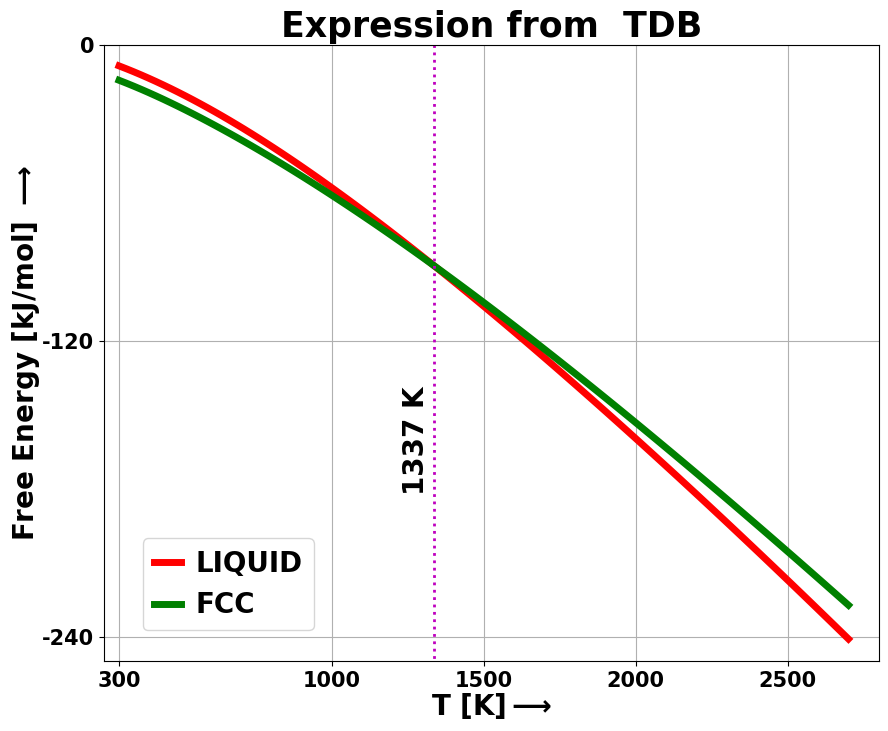

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize=[10, 8])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2)

ax1.plot(temp_LIQ, G_LIQ, c='r', lw=5, label='LIQUID')
ax1.plot(temp_FCC, G_FCC, c='g', lw=5, label='FCC')
ax1.set_xlabel('Temperature (temp)')
ax1.set_ylabel('Function value')
ax1.legend()
ax1.grid(True)
ax1.set_ylim(-250000, 0)
ax1.set_xlim(250, 2800)
ax1.set_xticks([300, 1000, 1500, 2000, 2500], labels=[300, 1000, 1500, 2000, 2500], size=15, weight='bold', color='k')
ax1.set_yticks([0, -120_000, -240_000], labels=['0', '-120', '-240'], size=15, color='k', weight='bold')
ax1.set_ylabel(r"Free Energy [kJ/mol] $\mathbf{\longrightarrow}$", loc='center',  weight = 'bold', labelpad=0, size=20, color='k')
ax1.set_xlabel(r"T [K]$ \mathbf{\longrightarrow}$", loc='center',  weight = 'bold', labelpad=0, size=20, color='k')
ax1.set_title("Expression from  TDB", fontsize=25, weight='bold')
legend1 = ax1.legend(loc=(0.05, 0.05), ncol=1,  columnspacing=1.0, prop={'weight':'bold', 'size':'20',}, handletextpad=0.5, handlelength=1.0,   frameon=True).get_frame().set_facecolor('none')
ax1.vlines(x=1337, ymax=0, ymin=-300_000, linestyle=":", color='m', lw=2)
ax1.text(x=1230 ,y=-180_000 , s='1337 K', rotation=90, fontsize=20, weight='bold')


## Plotting Free Energy from Approximation using Polynomial Fitting

In [8]:
def Au_LIQ(temp):
    factor_f1, a1, b1, c1, d1, e1, f1, g_1, h_1, x1 = 12.3465, 1337, 18905, 11.2, 6.3, 0.0023, 0.0345, 0.000019, -17.4, 2227
    return factor_f1*(a1-b1-c1*(temp-x1)+d1*(temp-x1)*np.log(e1*temp)+f1*(temp-x1)**2+g_1*(temp-x1)**3+h_1/temp)

def Au_FCC(temp):
    factor_f2, a2, b2, c2, d2, e2, f2, g_2, h_2, x2 = 9.9782, 300, 4985, -49.663, -12, 0.235, -0.001, 0.00002, -0.001, 235
    return factor_f2*(a2-b2-c2*(temp-x2)+d2*(temp-x2)*np.log(e2*temp)+f2*(temp-x2)**2+g_2*(temp-x2)**3+h_2/temp)

temp = np.linspace(300, 3000, 100)

F1 = Au_LIQ(temp)
F2 = Au_FCC(temp)
int_pts = np.argwhere(np.diff(np.sign(F1 - F2))).flatten()

Au_LIQ_min = minimize(Au_LIQ, x0=[2000], method= 'Powell', bounds=[(1337, 3000)])
Au_FCC_min = minimize(Au_FCC, x0=[1000], method= 'Powell', bounds=[(300, 1337)])

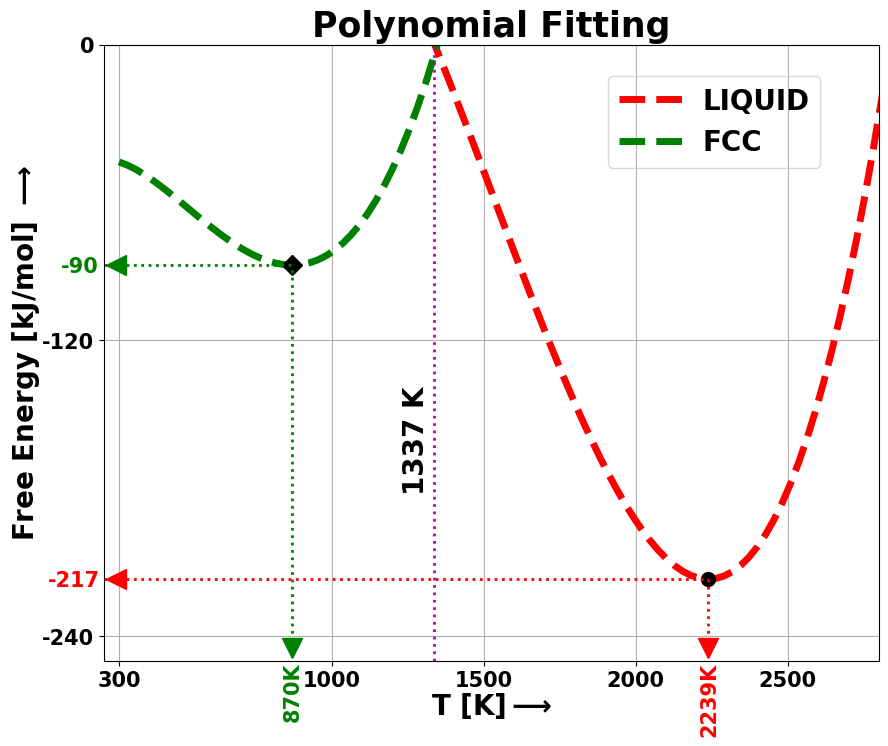

In [9]:
fig, ax2 = plt.subplots(1, 1, figsize=[10, 8])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2)

# ax2.scatter(x=Au_LIQ_min.x[0], y=Au_LIQ_min.fun.tolist(), marker='D', color = 'black', s=120)
# ax2.scatter(x=Au_FCC_min.x[0], y = Au_FCC_min.fun.tolist(), marker='X', color='black', s=120)

ax2.plot(temp, F1, c='r', lw=5, linestyle ='--', label='LIQUID')
ax2.plot(temp, F2, c='g', lw=5, linestyle ='--', label='FCC')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Free Energy')
ax2.legend()
ax2.grid(True)
ax2.set_ylim(-250000, 0)
ax2.set_xlim(250, 2800)
ax2.set_xticks([300, 1000, 1500, 2000, 2500], labels=[300, 1000, 1500, 2000, 2500], size=15, weight='bold', color='k')
ax2.set_yticks([0, -120_000, -240_000], labels=['0', '-120', '-240'], size=15, color='k', weight='bold')
ax2.set_ylabel(r"Free Energy [kJ/mol] $\mathbf{\longrightarrow}$", loc='center',  weight = 'bold', labelpad=0, size=20, color='k')
ax2.set_xlabel(r"T [K]$ \mathbf{\longrightarrow}$", loc='center',  weight = 'bold', labelpad=0, size=20, color='k')
ax2.set_title("Polynomial Fitting", fontsize=25, weight='bold')
legend2 = ax2.legend(loc=(0.65, 0.80), ncol=1,  columnspacing=1.0, prop={'weight':'bold', 'size':'20',}, handletextpad=0.5, handlelength=2.5,   frameon=True).get_frame().set_facecolor('none')
ax2.vlines(x=1337, ymax=0, ymin=-250_000, linestyle=":", color='m', lw=2)
ax2.text(x=1230 ,y=-180_000 , s='1337 K', rotation=90, fontsize=20, weight='bold')

ax2.plot(Au_LIQ_min.x, Au_LIQ_min.fun, marker = 'o', markersize=10, color='k')
ax2.plot(Au_FCC_min.x, Au_FCC_min.fun, marker = 'D', markersize=10, color='k')

ax2.vlines(x=Au_LIQ_min.x, ymax= Au_LIQ_min.fun, ymin=-245_000, linestyle=":", color='red', lw=2)
ax2.vlines(x=Au_FCC_min.x, ymax= Au_FCC_min.fun, ymin=-245_000, linestyle=":", color='green', lw=2)
ax2.hlines(y=Au_LIQ_min.fun, xmax= Au_LIQ_min.x, xmin=250, linestyle=":", color='red', lw=2)
ax2.hlines(y=Au_FCC_min.fun, xmax= Au_FCC_min.x, xmin=250, linestyle=":", color='green', lw=2)

ax2.plot(Au_LIQ_min.x, -245_000, marker='v', color='red', markersize=15)
ax2.plot(Au_FCC_min.x, -245_000, marker='v', color='green', markersize=15)
ax2.text(x=Au_FCC_min.x-30, y=-273_000 , s=f'{Au_FCC_min.x[0]:.0f}K', rotation=90, color='green', fontsize=15, weight='bold')
ax2.text(x=Au_LIQ_min.x-30, y=-279_000 , s=f'{Au_LIQ_min.x[0]:.0f}K', rotation=90, color='red', fontsize=15, weight='bold')

ax2.plot(290, Au_LIQ_min.fun, marker='<', color='red', markersize=15)
ax2.plot(290, Au_FCC_min.fun, marker='<', color='green', markersize=15)
ax2.text(x=110, y=Au_FCC_min.fun-3000, s=f'{Au_FCC_min.fun/1000:.0f}', rotation=0, color='green', fontsize=15, weight='bold')
ax2.text(x=65, y=Au_LIQ_min.fun-3000, s=f'{Au_LIQ_min.fun/1000:.0f}', rotation=0, color='red', fontsize=15, weight='bold')

plt.show()

## Both Figures Combined

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 8], frameon=False)
ax1.set_facecolor((0, 0, 0, 0))
ax2.set_facecolor((0, 0, 0, 0))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2)

ax1.plot(temp_LIQ, G_LIQ, c='r', lw=5, label='LIQUID')
ax1.plot(temp_FCC, G_FCC, c='g', lw=5, label='FCC')
ax1.set_xlabel('Temperature (temp)')
ax1.set_ylabel('Function value')
ax1.legend()
ax1.grid(True)
ax1.set_ylim(-250000, 0)
ax1.set_xlim(250, 2800)
ax1.set_xticks([300, 1000, 1500, 2000, 2500], labels=[300, 1000, 1500, 2000, 2500], size=17, weight='bold', color='k')
ax1.set_yticks([0, -120_000, -240_000], labels=['0', '-120', '-240'], size=17, color='k', weight='bold')
ax1.set_ylabel(r"Free Energy [kJ/mol] $\mathbf{\longrightarrow}$", loc='center',  weight = 'bold', labelpad=0, size=25, color='k')
ax1.set_xlabel(r"T [K]$ \mathbf{\longrightarrow}$", loc='center',  weight = 'bold', labelpad=10, size=25, color='k')
# ax1.set_title("Expression from  TDB", fontsize=25, weight='bold')
legend1 = ax1.legend(loc=(0.65, 0.80), ncol=1,  columnspacing=1.0, prop={'weight':'bold', 'size':'20',}, handletextpad=0.5, handlelength=1.0,   frameon=True).get_frame().set_facecolor('none')
ax1.vlines(x=1337, ymax=0, ymin=-300_000, linestyle=":", color='m', lw=2)
ax1.text(x=1230 ,y=-180_000 , s='1337 K', rotation=90, fontsize=20, weight='bold')


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2)

# ax2.scatter(x=Au_LIQ_min.x[0], y=Au_LIQ_min.fun.tolist(), marker='D', color = 'black', s=120)
# ax2.scatter(x=Au_FCC_min.x[0], y = Au_FCC_min.fun.tolist(), marker='X', color='black', s=120)

ax2.plot(temp, F1, c='r', lw=5, linestyle ='--', label='LIQUID')
ax2.plot(temp, F2, c='g', lw=5, linestyle ='--', label='FCC')
ax2.legend()
ax2.grid(True)
ax2.set_ylim(-250000, 0)
ax2.set_xlim(250, 2800)
ax2.set_xticks([300, 1000, 1500, 2000, 2500], labels=[300, 1000, 1500, 2000, 2500], size=17, weight='bold', color='k')
ax2.set_yticks([0, -120_000, -240_000], labels=['0', '-120', '-240'], size=17, color='k', weight='bold')
ax2.set_ylabel(r"Free Energy [kJ/mol] $\mathbf{\longrightarrow}$", loc='center',  weight = 'bold', labelpad=0, size=25, color='k')
ax2.set_xlabel(r"T [K]$ \mathbf{\longrightarrow}$", loc='center',  weight = 'bold', labelpad=10, size=25, color='k')
# ax2.set_title("Polynomial Fitting", fontsize=25, weight='bold')
legend2 = ax2.legend(loc=(0.65, 0.80), ncol=1,  columnspacing=1.0, prop={'weight':'bold', 'size':'20',}, handletextpad=0.5, handlelength=2.5,   frameon=True).get_frame().set_facecolor('none')
ax2.vlines(x=1337, ymax=0, ymin=-250_000, linestyle=":", color='m', lw=2)
ax2.text(x=1230 ,y=-180_000 , s='1337 K', rotation=90, fontsize=20, weight='bold')

ax2.plot(Au_LIQ_min.x, Au_LIQ_min.fun, marker = 'o', markersize=10, color='k')
ax2.plot(Au_FCC_min.x, Au_FCC_min.fun, marker = 'D', markersize=10, color='k')

ax2.vlines(x=Au_LIQ_min.x, ymax= Au_LIQ_min.fun, ymin=-245_000, linestyle=":", color='red', lw=2)
ax2.vlines(x=Au_FCC_min.x, ymax= Au_FCC_min.fun, ymin=-245_000, linestyle=":", color='green', lw=2)
ax2.hlines(y=Au_LIQ_min.fun, xmax= Au_LIQ_min.x, xmin=250, linestyle=":", color='red', lw=2)
ax2.hlines(y=Au_FCC_min.fun, xmax= Au_FCC_min.x, xmin=250, linestyle=":", color='green', lw=2)

ax2.plot(Au_LIQ_min.x, -245_000, marker='v', color='red', markersize=15)
ax2.plot(Au_FCC_min.x, -245_000, marker='v', color='green', markersize=15)
ax2.text(x=Au_FCC_min.x-50, y=-273_000 , s=f'{Au_FCC_min.x[0]:.0f}K', rotation=90, color='green', fontsize=15, weight='bold')
ax2.text(x=Au_LIQ_min.x-30, y=-279_000 , s=f'{Au_LIQ_min.x[0]:.0f}K', rotation=90, color='red', fontsize=15, weight='bold')

ax2.plot(290, Au_LIQ_min.fun, marker='<', color='red', markersize=15)
ax2.plot(290, Au_FCC_min.fun, marker='<', color='green', markersize=15)
ax2.text(x=100, y=Au_FCC_min.fun-3000, s=f'{Au_FCC_min.fun/1000:.0f}', rotation=0, color='green', fontsize=15, weight='bold')
ax2.text(x=50, y=Au_LIQ_min.fun-3000, s=f'{Au_LIQ_min.fun/1000:.0f}', rotation=0, color='red', fontsize=15, weight='bold')


# plt.savefig('../../4_Manuscript_Figures/free_energy.png',bbox_inches='tight', dpi=800)

plt.show()